### Standard Logistic Regression

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [14]:
from pathlib import Path
import pandas as pd

# Ensure you have created a "data" folder in your project directory 
# and downloaded the CSV file inside it.
file_path = Path.cwd().parent / "data" / "athens_weather_df_2019_2023.csv"

# Load dataset with index and date parsing
lagged_1h_df = pd.read_csv(file_path, parse_dates=["date"])

In [15]:
import pickle

# Load the list of variables to transform
variables_to_transform_path = "../data/variables_to_transform.pkl"

with open(variables_to_transform_path, "rb") as f:
    variables_to_transform = pickle.load(f)

print(variables_to_transform)

['direct_radiation_lag_1h', 'cloud_cover_mid_lag_1h', 'cloud_cover_low_lag_1h', 'vapour_pressure_deficit_lag_1h', 'evapotranspiration_lag_1h']


We will begin the modeling phase by instantiating a Logistic Regression model with default settings, without any adjustments for class imbalance. This model will serve as our baseline, providing a reference point against which, we can compare other potentially more complex, adjusted models and offer a straightforward and intuitive way to compare different model implementations.

- separate the dataset into input space X (the predictor variables) and to output space y (the target/response) variable

In [16]:
X = lagged_1h_df.drop(columns=['date', 'weather_event'])
y = lagged_1h_df['weather_event']

- data is split into a training set (70%) and a test set (30%) using stratified sampling to maintain the proportions of the classes for the target variable y in both sets. This ensures that the model is trained and evaluated with the same label distribution. The random state is set for reproducibility.

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

After splitting the data into train and test sets, we are ready to build the model's pipeline.   
In this standard logistic regression approach, the pipeline will include two preprocessing steps:
- Scaling the Data:
We will use the RobustScaler() to scale the data, as it is resilient to outliers and ensures features are on a similar scale, which is important for logistic regression.
- Model Instantiation:
We will instantiate the LogisticRegression() class, and set the `multi_class` argument to 'multinomial'.

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Define the preprocessing step for Yeo-Johnson transformation
preprocessor = ColumnTransformer([
    ('yeo_johnson', PowerTransformer(method='yeo-johnson'), variables_to_transform),
], remainder='passthrough')  # Leave other features untouched

# Define the pipeline
standard_pipeline = Pipeline([
    ('preprocessing', preprocessor),   # Step 1: Yeo-Johnson transformation for specific variables
    ('scaling', RobustScaler()),       # Step 2: Scale all features
    ('standard_model', LogisticRegression(
        max_iter=1500,
        random_state=42,
        solver='lbfgs',
        n_jobs=-1
    ))
])


import time
start = time.time()

# Step 3: Fit the pipeline to the training data
standard_pipeline.fit(X_train, y_train)

# Execution time and number of iterations for the solver to converge
execution_time = time.time() - start
n_iterations = standard_pipeline['standard_model'].n_iter_
print(f"Execution time: {execution_time:.2f} seconds")
print(f"Number of iterations to converge: {n_iterations}")

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('yeo_johnson',
                                                  PowerTransformer(),
                                                  ['direct_radiation_lag_1h',
                                                   'cloud_cover_mid_lag_1h',
                                                   'cloud_cover_low_lag_1h',
                                                   'vapour_pressure_deficit_lag_1h',
                                                   'evapotranspiration_lag_1h'])])),
                ('scaling', RobustScaler()),
                ('standard_model',
                 LogisticRegression(max_iter=1500, n_jobs=-1,
                                    random_state=42))])

Execution time: 1.81 seconds
Number of iterations to converge: [106]


- extracting the predicted values of y by passing the test set features (X_test) into the trained model

In [20]:
y_pred_standard = standard_pipeline.predict(X_test)

#### **Model Evaluation**

Before evaluating the model on the test set (the truly *"unseen"* data), we will use a 10-fold cross-validation on the train dataset.   
This step provides an estimate of the model's performance, consistency, and stability across different subsets of the train data, helping us understand what to expect from the model.   

The scoring metric used for assessment is Balanced Accuracy, which is defined as the average recall across all classes. This is particularly useful in heavily imbalanced datasets when the primary concern is ensuring the model correctly identifies actual positive instances for each class, reducing the risk of missing Rain and Snowfall events.   
In contrast, F1-macro and PR AUC-macro, which treat all classes equally, can understate overall performance if the model struggles with minority classes. Meanwhile, F1-weighted and PR AUC-weighted tend to be overly optimistic, as they are heavily influenced by the majority class. Balanced Accuracy avoids these pitfalls by focusing explicitly on recall and ensuring that all classes contribute equally to the final score, making it a more reliable metric in this context.

You can find more information about the cv evaluation of the train data as well as the most suitable metrics to use in the links below:   
https://scikit-learn.org/stable/modules/cross_validation.html   
https://scikit-learn.org/stable/modules/model_evaluation.html   
https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/

##### **CV evaluation**

- Setting up a 10-fold cross-validation with stratified sampling to ensure that each fold has the same proportion of classes as the original dataset. Setting the random state to ensure reproducibility.

In [21]:
from sklearn.model_selection import StratifiedKFold
stkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

- run the cv assessment on the train data using the 10-folds created in the previous step. Printing the mean value of the metric across all folds along with its standard deviation.

In [22]:
from sklearn.model_selection import cross_val_score
logreg_standard_cv = cross_val_score(standard_pipeline, X_train, y_train, cv=stkf, scoring='balanced_accuracy', n_jobs=-1)
print(logreg_standard_cv)
print(f'\nThe mean value of balanced_accuracy is {logreg_standard_cv.mean().round(3)}')
print(f'\nThe standard deviation of balanced_accuracy is {logreg_standard_cv.std().round(3)}')

[0.64805944 0.633016   0.56550416 0.47608515 0.48044167 0.54746472
 0.65748447 0.57038859 0.47181831 0.47889566]

The mean value of balanced_accuracy is 0.553

The standard deviation of balanced_accuracy is 0.071


The cross-validation results indicate that the model consistently performs poorly, likely due to the **unaddressed class imbalance**. We will further explore and justify this observation using the confusion matrix to assess the model's performance on the unseen test dataset across all target classes.

##### **The Confusion Matrix**

Generating the confusion matrix to visualize the performance of the model **on the test set** this time.   
The confusion matrix shows how well the model predicted each class by displaying the true positive, false positive, true negative, and false negative counts for each class ('No Precipitation', 'Rain', 'Snowfall').

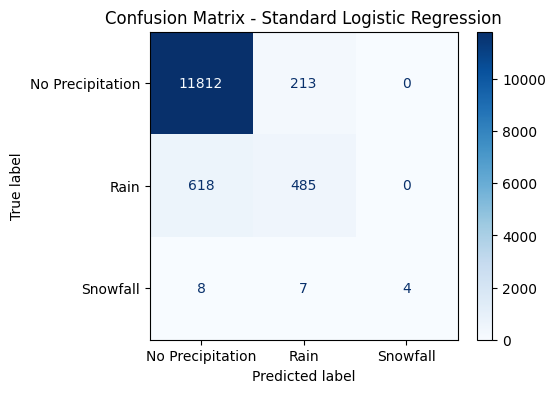

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
conf_matrix_standard = confusion_matrix(y_test, y_pred_standard)
fig, ax = plt.subplots(figsize=(5, 4))
disp = ConfusionMatrixDisplay(conf_matrix_standard, display_labels=['No Precipitation', 'Rain', 'Snowfall'])
plot = disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
title = plt.title('Confusion Matrix - Standard Logistic Regression')
plt.show()

It is evident that the severe imbalance in the target classes significantly impacted the model's performance, as seen in the confusion matrix above.   
The model performed very well in predicting instances of the majority class ('No Precipitation'), correctly identifying 11812 out of a total of 12025 instances. However, when it came to the minority classes, the model struggled. For 'Rain' events, it correctly predicted less than half of the instances (487 out of 1,103), and for the 'Snowfall' class, the model captured only 4 out of 19 events.   
This is a common challenge in classification tasks when dealing with imbalanced datasets, where the model tends to favor the majority class at the expense of the minority classes.

- save the confusion matrix for later use

In [24]:
from joblib import dump

# Define the file path
conf_matrix_path = "../reports/03_standard_logistic_regression_confusion_matrix.joblib"

# Save the confusion matrix
dump(conf_matrix_standard, conf_matrix_path)

print(f"Confusion matrix saved at: {conf_matrix_path}")

['../reports/03_standard_logistic_regression_confusion_matrix.joblib']

Confusion matrix saved at: ../reports/03_standard_logistic_regression_confusion_matrix.joblib


##### **The Precision-Recall Curve**

The next step in evaluating the model’s performance on the test set is to compute the Precision-Recall (PR) curve for each class: No Precipitation, Rain, and Snowfall. The PR curve visualizes the trade-off between precision and recall across various probability thresholds, making it a valuable tool for assessing models on imbalanced datasets.

This curve is particularly valuable for imbalanced datasets because it highlights how well the model performs on minority classes.   
As recall (the proportion of true positive predictions out of all actual positives) increases, the model tends to capture more true positive instances.
However, this often comes at the cost of precision (the proportion of true positive predictions out of all predicted positives), as more false positive predictions are introduced.

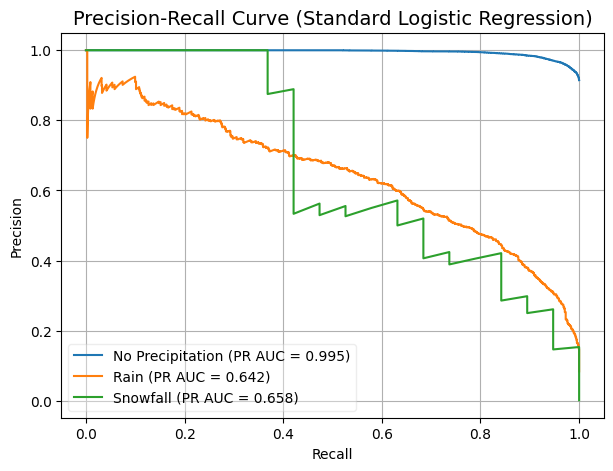

In [25]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Predicted probabilities
y_pred_probs_standard = standard_pipeline.predict_proba(X_test)

# Define class labels
class_labels = ['No Precipitation', 'Rain', 'Snowfall']

# Plot Precision-Recall curves
figure = plt.figure(figsize=(7, 5)) 
for i, label in enumerate(class_labels):  
    precision, recall, _ = precision_recall_curve(y_test == i, y_pred_probs_standard[:, i])
    pr_auc = auc(recall, precision)
    
    # Plot the precision-recall curve
    curve_plot = plt.plot(recall, precision, label=f'{label} (PR AUC = {pr_auc:.3f})')

# Add labels, title, and legend
xlabel = plt.xlabel('Recall')
ylabel = plt.ylabel('Precision')
title =plt.title('Precision-Recall Curve (Standard Logistic Regression)', fontsize=14)
legend = plt.legend(loc='lower left', framealpha=0.35)
grid = plt.grid(True)
plt.show()

The precision-recall curve highlights the poor performance of the model on the minority classes due to severe class imbalance.

While the model performs exceptionally well on 'No Precipitation' instances, this was expected. Even a dummy classifier that always predicts 'No Precipitation' would achieve a precision approximately equal to the majority class proportion (~91.5%). This is a well-known issue in severely imbalanced datasets, where the model becomes heavily biased toward the majority class.

However, when it comes to minority classes ('Rain' and 'Snowfall'), the model struggles to classify them correctly. As it attempts to improve recall, the false positives (FPs) increase, leading to a sharp decline in precision. When recall reaches 1 (capturing all minority instances), precision drops to zero, indicating that perfectly capturing the minority classes comes at the cost of excessive misclassifications.

This is a classic precision-recall trade-off inherent in imbalanced datasets, and its effects are further amplified as class imbalance becomes more severe. This behavior highlights the importance of balancing precision and recall, to achieve optimal performance for each class.

##### **The Classification Report**

One more step in evaluating the model is to create a classification report, summarizing key metrics for each class:
precision, recall, F1-score, and PR AUC (Precision-Recall Area Under the Curve).
The classification report provides a detailed breakdown of these metrics for each class:
No Precipitation, Rain, and Snowfall.

Additionally, we calculate overall metrics:
- balanced_accuracy: more suitable for imbalanced datasets compared to simple accuracy.
- f1_macro: calculate the metric for each label and find their unweighted mean. This does not take label imbalance into account.
- pr_auc_macro: the unweighted average of the precision-recall AUC scores computed separately for each class, treating all classes equally.
 
We transformed the report to a single-row DataFrame so as to make future comparisons with other models easier.

In [26]:
from sklearn.metrics import (
    classification_report, balanced_accuracy_score, f1_score, 
    average_precision_score, precision_recall_curve, auc
)

report_dict_standard = classification_report(y_test, y_pred_standard, digits=3, output_dict=True)
y_pred_probs_standard = standard_pipeline.predict_proba(X_test)

# Calculate PR AUC for each class
precision_0, recall_0, _ = precision_recall_curve(y_test == 0, y_pred_probs_standard[:, 0])
pr_auc_0 = auc(recall_0, precision_0)

precision_rain, recall_rain, _ = precision_recall_curve(y_test == 1, y_pred_probs_standard[:, 1])
pr_auc_rain = auc(recall_rain, precision_rain)

precision_snow, recall_snow, _ = precision_recall_curve(y_test == 2, y_pred_probs_standard[:, 2])
pr_auc_snow = auc(recall_snow, precision_snow)

# Create a single row dataframe with the required metrics
report_df_standard = pd.DataFrame({
    'precision_0': [report_dict_standard['0']['precision']],
    'recall_0': [report_dict_standard['0']['recall']],
    'f1_0': [report_dict_standard['0']['f1-score']],
    'pr_auc_0': [pr_auc_0],
    
    'precision_rain': [report_dict_standard['1']['precision']],
    'recall_rain': [report_dict_standard['1']['recall']],
    'f1_rain': [report_dict_standard['1']['f1-score']],
    'pr_auc_rain': [pr_auc_rain],
    
    'precision_snow': [report_dict_standard['2']['precision']],
    'recall_snow': [report_dict_standard['2']['recall']],
    'f1_snow': [report_dict_standard['2']['f1-score']],
    'pr_auc_snow': [pr_auc_snow],
    'balanced_accuracy': [balanced_accuracy_score(y_test, y_pred_standard)],
    'f1_macro': [f1_score(y_test, y_pred_standard, average='macro')],
    'pr_auc_macro': [average_precision_score(y_test, y_pred_probs_standard, average='macro')]
})

print('Standard Logistic Regression')
report_df_standard = report_df_standard.round(4)
report_df_standard

Standard Logistic Regression


,precision_0,recall_0,f1_0,pr_auc_0,precision_rain,recall_rain,f1_rain,pr_auc_rain,precision_snow,recall_snow,f1_snow,pr_auc_snow,balanced_accuracy,f1_macro,pr_auc_macro
0,0.9497,0.9823,0.9657,0.9949,0.6879,0.4397,0.5365,0.6419,1.0,0.2105,0.3478,0.6581,0.5442,0.6167,0.767


- save the metrics report for later use

In [27]:
# Define the file path
report_path = "../reports/03_standard_logistic_regression_report.joblib"

# Save the report DataFrame
dump(report_df_standard, report_path)

print(f"Metrics report saved at: {report_path}")

['../reports/03_standard_logistic_regression_report.joblib']

Metrics report saved at: ../reports/03_standard_logistic_regression_report.joblib


##### **The learning curve**

Before interpreting a learning curve to gain insights into a model's performance, we must first understand what it represents.

A learning curve illustrates how a model's performance evolves as the dataset size increases, helping us diagnose underfitting, overfitting, and generalization ability. In our case, we use log-loss to track how the error in predictions changes as more training data is provided.

Each point on the curve represents the average performance across cross-validation folds for a specific training size, offering an estimate of how well the model performs with different data volumes. This allows us to observe whether model performance improves, deteriorates, or plateaus with additional data.

In the plot, we have two curves: one (yellow) represents the average metric score on the training dataset, and the other (purple) represents the average metric score on the validation/test dataset.   
- If both curves are low relative to the y-axis and close to each other, the model may not be complex enough to capture data patterns and is likely underfitting.
- If the training curve is high but the validation curve is low, the model might be memorizing the training data without generalizing well, indicating overfitting.
- If both curves converge at a high level, the model is likely to perform well and generalizing effectively.

It is also important to observe whether the curves increase, plateau, or fluctuate as more data is fed to the model, as this indicates how additional data impacts performance.

Finally, you shouldn’t expect the performance metric on the test set from stratified cross-validation on the full dataset to exactly match the final point on the learning curve. Due to data randomness and differences in train-validation splits, the training and validation sets in the final point of the learning curve may differ from those used in a cross-validation on the full dataset, leading to slight variations in metric results. The learning curve’s final point represents the average of cross-validated scores across multiple folds, while the test set score is a single evaluation on a fixed data split.

However, if the difference between the two metrics is significant, it’s worth investigating further. Potential issues could include model instability due to high complexity, overfitting to specific patterns in the data and more.

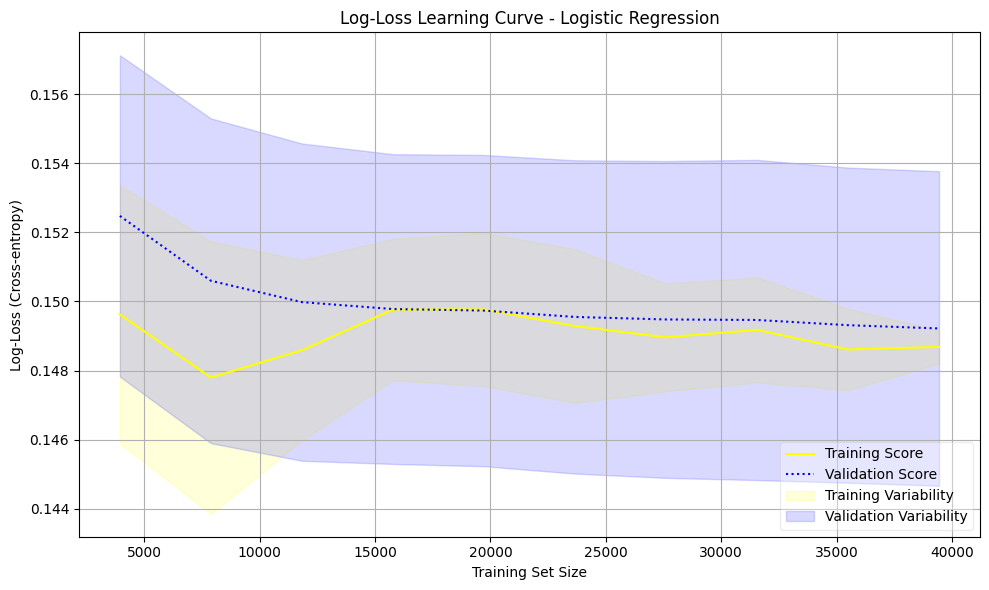

In [28]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
stkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    standard_pipeline, X, y, cv=stkf, scoring='neg_log_loss', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
)

train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

figure = plt.figure(figsize=(10, 6))
plot1 = plt.plot(train_sizes, train_mean, label='Training Score', color='yellow')
plot2 = plt.plot(train_sizes, test_mean, label='Validation Score', color='blue', linestyle=':')
ce1_fill = plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='yellow', 
                            alpha=0.15, label='Training Variability')
ce2_fill = plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='blue',
                            alpha=0.15, label='Validation Variability')

xlabel = plt.xlabel('Training Set Size')
ylabel = plt.ylabel('Log-Loss (Cross-entropy)')
title = plt.title('Log-Loss Learning Curve - Logistic Regression')
legend = plt.legend(loc='lower right', framealpha=0.35)
grid = plt.grid(True)
plt.tight_layout()
plt.show()

<u>Inferences from the Learning Curve Plot</u>   

The log-loss of the training and validation sets converge and plateau around 0.149, when the full dataset is used to train the model. The small gap between the two curves indicates no signs of overfitting, suggesting that the model is well-calibrated to the data, but further improvement are not expected.

The noticeable variance in validation loss, indicates that the performance varies across different validation splits, and suggests that the model struggles to generalize consistently on unseen data. This could be due to data complexity and severe class imbalance.

**Save the Trained Model**

In [29]:
# Define the file path
model_path = "../models/standard_logistic_regression.joblib"

# Save the entire pipeline
dump(standard_pipeline, model_path)

print(f"Standard Logistic Regression model saved at: {model_path}")

['../models/standard_logistic_regression.joblib']

Standard Logistic Regression model saved at: ../models/standard_logistic_regression.joblib
